In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
import torch
import kornia as K

from pathlib import Path
from PIL import Image
from pprint import pprint

from torch import nn, optim
from torchvision.models import mobilenet_v3_large
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

# custom imports
from fairface_classification import data

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface')

%matplotlib inline
%load_ext autoreload
%autoreload 2

### The following is the model architecture I am going to train on FairFace Dataset

Almost the whole model and its architecture - Mobile Net V3 Large pretrained on ImageNet dataset. The last layer is modified and adapted to current FairFace dataset. There are just 3 classes that should predicted at the same time, so the last layer of the model will have three "heads".

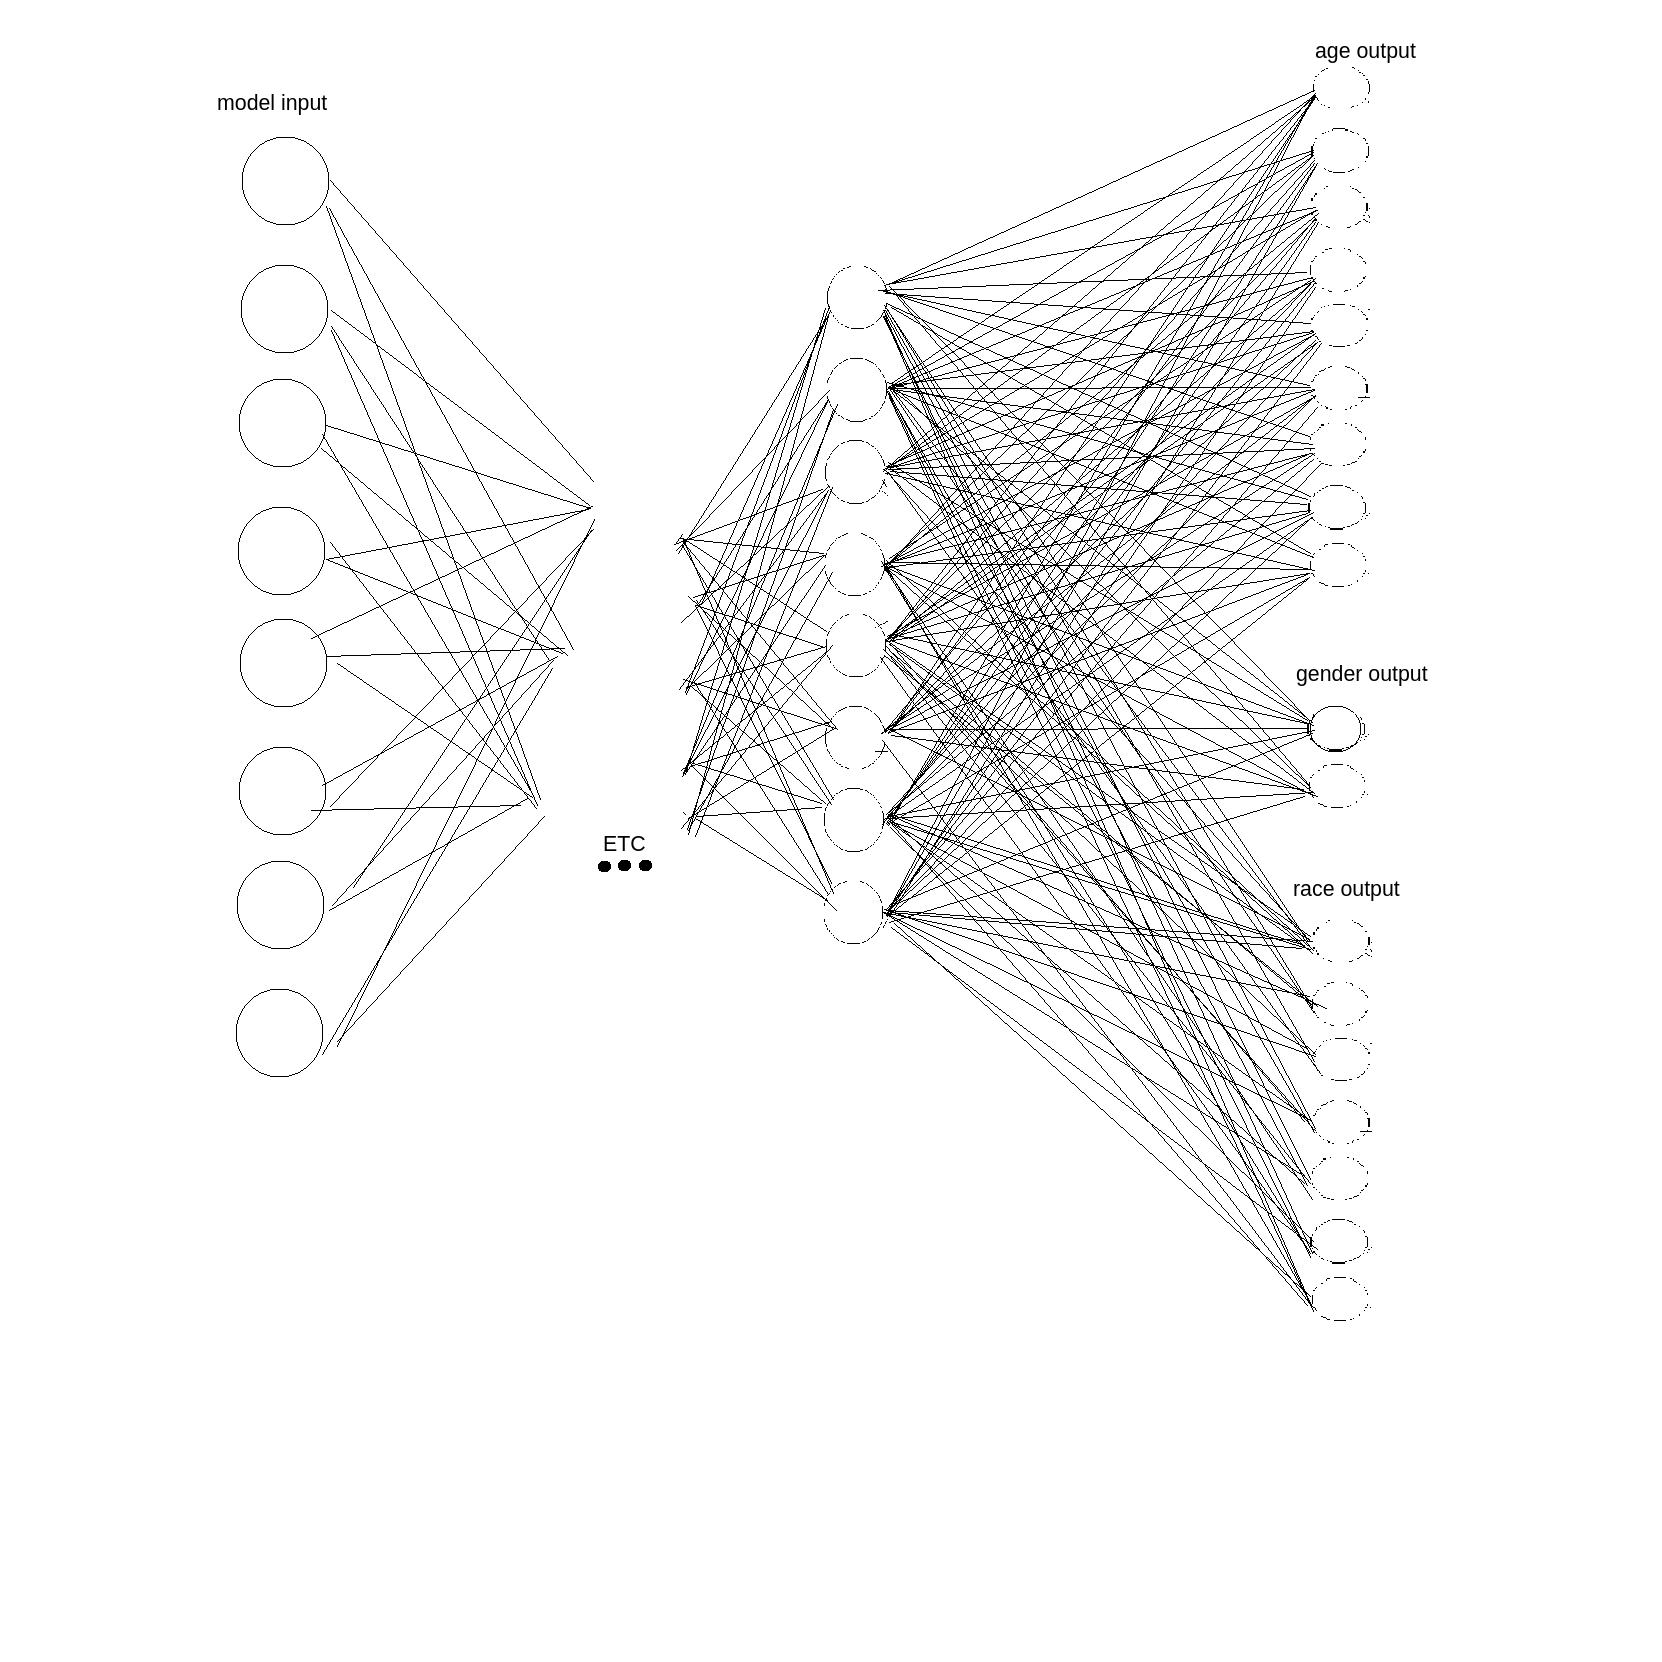

In [2]:
Image.open('../model_architecture.png')

In [3]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V1')
print(f'Mobilenet pretrained on ImageNet1k_V1 = {mobilenet}')
train_label.head()

Mobilenet pretrained on ImageNet1k_V1 = MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 6

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [4]:
root_dir = Path('/home/himars/Programming/Deep_Learning/fairface_classification/')
images_dir = 'data/'

print(root_dir, images_dir, sep='\n')

/home/himars/Programming/Deep_Learning/fairface_classification
data/


### Initialize Dataset and Dataloader

In [5]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 7,
         '10-19': 4,
         '20-29': 0,
         '3-9': 3,
         '30-39': 1,
         '40-49': 2,
         '50-59': 5,
         '60-69': 6,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [6]:
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(), 
                                                                      transforms.RandomHorizontalFlip(0.5),
                                                                      transforms.RandomAffine([-15, 15]),
                                                                      transforms.RandomPerspective(0.5),
                                                                      transforms.RandomSolarize(threshold=0.8, p=0.1),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                                      ]))
fairface_train.train()
train_loader = DataLoader(fairface_train, batch_size=32, shuffle=True, num_workers=5)

fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
fairface_test.train()
test_loader = DataLoader(fairface_test, batch_size=32, shuffle=True, num_workers=5)

fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
fairface_val.train()
val_loader = DataLoader(fairface_val, batch_size=32, shuffle=True, num_workers=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


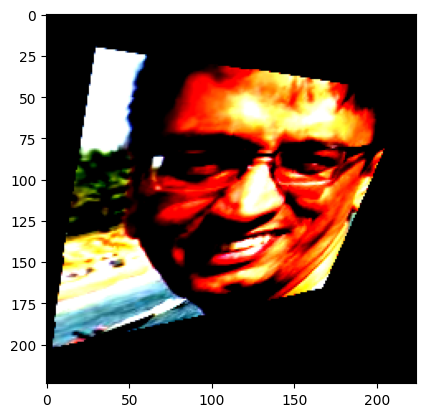

In [7]:
plt.imshow(torch.squeeze(fairface_train[43]['image']).permute(1, 2, 0))
plt.show()

### Sample data

In [8]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[43 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

### First try of training a neural network

In [9]:
class FairFaceMobileNet(nn.Module):
    def __init__(self, MobileNet) -> None:
        super(FairFaceMobileNet, self).__init__()
        self.mobilenet = MobileNet
        for param in self.mobilenet.parameters():
            param.requires_grad = False

        # self.fc1 = torch.nn.Linear(960, 9) # for age class
        self.fc1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                                 nn.Flatten(), 
                                 nn.Linear(960, 9))
        self.fc2 = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                                 nn.Flatten(), 
                                 nn.Linear(960, 2))
        self.fc3 = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                                 nn.Flatten(), 
                                 nn.Linear(960, 7))

    def forward(self, x):

        x = self.mobilenet.features(x)

        age = torch.softmax(self.fc1(x), dim=1)
        gender = torch.softmax(self.fc2(x), dim=1)

        race = torch.softmax(self.fc3(x), dim=1)

        return {'age_pred' : age, 'gender_pred' : gender, 'race_pred' : race}


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mobilenet = mobilenet.to(device)
model = FairFaceMobileNet(mobilenet).to(device)

# For race and age classes
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

def train_model(model, criterion, optimizer, device, loaders, tensor_writer, n_epochs=25):

    """Fine-tune the model and returns it"""

    train_loader, test_loader = loaders

    data.check_train_mode_off(train_loader, 'train')
    data.check_train_mode_off(test_loader, 'test')

    valid_loss_min = torch.inf

    n_total_steps = len(train_loader)
    

    for epoch in range(1, n_epochs):
        train_loss = .0
        model.train()

        all_age_preds = []
        all_age_labels = []

        all_gender_preds = []
        all_gender_labels = []

        all_race_preds = []
        all_race_labels = []

        train_loss = .0

        for batch_idx, sample_batched in enumerate(tqdm(train_loader)):
            image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
            gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            output = model(image)
            # predict age, gender, race labels
            age_pred = output['age_pred'].to(device)
            gender_pred = output['gender_pred'].to(device)
            race_pred = output['race_pred'].to(device)
            
            # calculate loss
            age_loss = criterion(age_pred, age)
            race_loss = criterion(race_pred, race)
            gender_loss = criterion(gender_pred, gender)

            # total loss and back propagation
            loss = age_loss + race_loss + gender_loss

            train_loss += loss

            loss.backward()
            # optimization step
            optimizer.step()

            # Age accuracy
            _, age_predicted = torch.max(output['age_pred'].data, 1)
            # Race accuracy
            _, race_predicted = torch.max(output['race_pred'].data, 1)
            # Gender accuracy
            _, gender_predicted = torch.max(output['gender_pred'].data, 1)

            all_age_preds.extend([i.item() for i in age_predicted])
            all_gender_preds.extend([i.item() for i in gender_predicted])
            all_race_preds.extend([i.item() for i in race_predicted])

            all_age_labels.extend([i.item() for i in age])
            all_gender_labels.extend([i.item() for i in gender])
            all_race_labels.extend([i.item() for i in race])
            
            if batch_idx % 500 == 0:
                print(f'Epoch = {epoch}, Batch = {batch_idx + 1}, Loss = {loss}')
                print(f'Age accuracy = {accuracy_score(all_age_labels, all_age_preds)}\tRace accuracy = {accuracy_score(all_race_labels, all_race_preds)}\tGender accuracy = {accuracy_score(all_gender_labels, all_gender_preds)}')
                print(f'Age loss = {age_loss}\tRace loss = {race_loss}\tGender Loss = {gender_loss}')
                tensor_writer.add_scalar('Training Loss', loss, epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Age Train Loss', age_loss, epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Race Train Loss', race_loss, epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Gender Train Loss', gender_loss, epoch * n_total_steps + batch_idx)

                tensor_writer.add_scalar('Age Train accuracy', accuracy_score(all_age_labels, all_age_preds), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Race Train accuracy', accuracy_score(all_race_labels, all_race_preds), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Gender Train accuracy', accuracy_score(all_gender_labels, all_gender_preds), epoch * n_total_steps + batch_idx)

                tensor_writer.add_scalar('Age Train f1', f1_score(all_age_labels, all_age_preds, average='macro'), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Race Train f1', f1_score(all_race_labels, all_race_preds, average='macro'), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Gender Train f1', f1_score(all_gender_labels, all_gender_preds, average='macro'), epoch * n_total_steps + batch_idx)

                tensor_writer.add_scalar('Age Train precision', precision_score(all_age_labels, all_age_preds, average='macro'), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Race Train precision', precision_score(all_race_labels, all_race_preds, average='macro'), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Gender Train precision', precision_score(all_gender_labels, all_gender_preds, average='macro'), epoch * n_total_steps + batch_idx)

                tensor_writer.add_scalar('Age Train recall', recall_score(all_age_labels, all_age_preds, average='macro'), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Race Train recall', recall_score(all_race_labels, all_race_preds, average='macro'), epoch * n_total_steps + batch_idx)
                tensor_writer.add_scalar('Gender Train recall', recall_score(all_gender_labels, all_gender_preds, average='macro'), epoch * n_total_steps + batch_idx)

                all_age_preds.clear()
                all_gender_preds.clear()
                all_race_preds.clear()

                all_age_labels.clear()
                all_gender_labels.clear()
                all_race_labels.clear()

        with torch.no_grad():
            valid_age_preds = []
            valid_age_labels = []

            valid_gender_preds = []
            valid_gender_labels = []

            valid_race_preds = []
            valid_race_labels = []

            valid_loss = .0
            valid_age_loss, valid_race_loss, valid_gender_loss = .0, .0, .0

            for batch_idx, sample_batched in enumerate(tqdm(test_loader)):
                image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
                gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)


                output = model(image)

                age_pred = output['age_pred'].to(device)
                gender_pred = output['gender_pred'].to(device)
                race_pred = output['race_pred'].to(device)

                age_loss = criterion(age_pred, age)
                race_loss = criterion(race_pred, race)
                gender_loss = criterion(gender_pred, gender)
                loss = age_loss + race_loss + gender_loss

                valid_loss += loss.item()
                valid_age_loss += age_loss
                valid_race_loss += race_loss
                valid_gender_loss += gender_loss

                # Age accuracy
                _, age_predicted = torch.max(output['age_pred'].data, 1)
                # Race accuracy
                _, race_predicted = torch.max(output['race_pred'].data, 1)
                # Gender accuracy
                _, gender_predicted = torch.max(output['gender_pred'].data, 1)

                valid_age_preds.extend([i.item() for i in age_predicted])
                valid_gender_preds.extend([i.item() for i in gender_predicted])
                valid_race_preds.extend([i.item() for i in race_predicted])

                valid_age_labels.extend([i.item() for i in age])
                valid_gender_labels.extend([i.item() for i in gender])
                valid_race_labels.extend([i.item() for i in race])

            print('Validation step:')
            print(f'Epoch = {epoch}, Batch = {batch_idx + 1}, Loss = {loss / len(test_loader)}')
            print(f'Age accuracy = {accuracy_score(valid_age_labels, valid_age_preds)}\tRace accuracy = {accuracy_score(valid_race_labels, valid_race_preds)}\tGender accuracy = {accuracy_score(valid_gender_labels, valid_gender_preds)}')
            tensor_writer.add_scalar('Validation Loss', loss / len(test_loader), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Age Vaidation Loss', age_loss / len(test_loader), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Race Vaidation Loss', race_loss / len(test_loader), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Gender Vaidation Loss', gender_loss / len(test_loader), epoch * n_total_steps + batch_idx)

            tensor_writer.add_scalar('Age Vaidation accuracy', accuracy_score(valid_age_labels, valid_age_preds), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Race Vaidation accuracy', accuracy_score(valid_race_labels, valid_race_preds), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Gender Vaidation accuracy', accuracy_score(valid_gender_labels, valid_gender_preds), epoch * n_total_steps + batch_idx)

            tensor_writer.add_scalar('Age Vaidation f1', f1_score(valid_age_labels, valid_age_preds, average='macro'), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Race Vaidation f1', f1_score(valid_race_labels, valid_race_preds, average='macro'), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Gender Vaidation f1', f1_score(valid_gender_labels, valid_gender_preds, average='macro'), epoch * n_total_steps + batch_idx)

            tensor_writer.add_scalar('Age Vaidation precision', precision_score(valid_age_labels, valid_age_preds, average='macro'), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Race Vaidation precision', precision_score(valid_race_labels, valid_race_preds, average='macro'), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Gender Vaidation precision', precision_score(valid_gender_labels, valid_gender_preds, average='macro'), epoch * n_total_steps + batch_idx)

            tensor_writer.add_scalar('Age Vaidation recall', recall_score(valid_age_labels, valid_age_preds, average='macro'), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Race Vaidation recall', recall_score(valid_race_labels, valid_race_preds, average='macro'), epoch * n_total_steps + batch_idx)
            tensor_writer.add_scalar('Gender Vaidation recall', recall_score(valid_gender_labels, valid_gender_preds, average='macro'), epoch * n_total_steps + batch_idx)


        # print training/validation statistics 
        print(f'End of Epoch: {epoch} \tTraining Loss: {train_loss / len(train_loader)} \tValidation Loss: {valid_loss / len(test_loader)}')
        
        if valid_loss < valid_loss_min:
            torch.save(model, 'model.pt')
            print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...')
            valid_loss_min = valid_loss

    # return trained model
    return model
best_model = train_model(model, criterion, optimizer, device=device, loaders=[train_loader, test_loader],tensor_writer=writer,n_epochs=25)

  0%|          | 2/2169 [00:03<46:12,  1.28s/it]  

Epoch = 1, Batch = 1, Loss = 4.8928751945495605
Age accuracy = 0.09375	Race accuracy = 0.09375	Gender accuracy = 0.34375
Age loss = 2.2028815746307373	Race loss = 1.955186367034912	Gender Loss = 0.734807550907135


 23%|██▎       | 500/2169 [01:03<03:25,  8.12it/s]

Epoch = 1, Batch = 501, Loss = 4.533112049102783
Age accuracy = 0.2898125	Race accuracy = 0.21825	Gender accuracy = 0.616
Age loss = 2.023516893386841	Race loss = 1.857677936553955	Gender Loss = 0.6519171595573425


 46%|████▌     | 1000/2169 [02:05<02:18,  8.44it/s]

Epoch = 1, Batch = 1001, Loss = 4.466204643249512
Age accuracy = 0.29975	Race accuracy = 0.28325	Gender accuracy = 0.6694375
Age loss = 1.9683887958526611	Race loss = 1.8944807052612305	Gender Loss = 0.6033351421356201


 69%|██████▉   | 1500/2169 [03:08<01:26,  7.70it/s]

Epoch = 1, Batch = 1501, Loss = 4.658820152282715
Age accuracy = 0.3028125	Race accuracy = 0.2979375	Gender accuracy = 0.6715
Age loss = 2.071418285369873	Race loss = 1.880426287651062	Gender Loss = 0.706975519657135


 92%|█████████▏| 2000/2169 [04:11<00:21,  7.91it/s]

Epoch = 1, Batch = 2001, Loss = 4.51657772064209
Age accuracy = 0.3078125	Race accuracy = 0.307625	Gender accuracy = 0.6794375
Age loss = 2.093449831008911	Race loss = 1.854390263557434	Gender Loss = 0.568737268447876


100%|██████████| 543/543 [00:55<00:00,  9.82it/s]


Validation step:
Epoch = 1, Batch = 543, Loss = 0.008609652519226074
Age accuracy = 0.30468614905758257	Race accuracy = 0.31673295290794856	Gender accuracy = 0.6915672373047438
End of Epoch: 1 	Training Loss: 4.575498580932617 	Validation Loss: 4.514290104474371
Validation loss decreased (inf --> 2451.2595267295837).  Saving model ...


  0%|          | 1/2169 [00:01<39:26,  1.09s/it]

Epoch = 2, Batch = 1, Loss = 4.445209980010986
Age accuracy = 0.28125	Race accuracy = 0.46875	Gender accuracy = 0.8125
Age loss = 2.1188223361968994	Race loss = 1.7553658485412598	Gender Loss = 0.5710219144821167


 23%|██▎       | 500/2169 [01:08<03:38,  7.64it/s]

Epoch = 2, Batch = 501, Loss = 4.612521648406982
Age accuracy = 0.3133125	Race accuracy = 0.3275	Gender accuracy = 0.691625
Age loss = 2.0774483680725098	Race loss = 1.8773174285888672	Gender Loss = 0.657755970954895


 46%|████▌     | 1000/2169 [02:16<02:41,  7.22it/s]

Epoch = 2, Batch = 1001, Loss = 4.510666370391846
Age accuracy = 0.3091875	Race accuracy = 0.327375	Gender accuracy = 0.6894375
Age loss = 2.0904462337493896	Race loss = 1.8808155059814453	Gender Loss = 0.5394048094749451


 69%|██████▉   | 1500/2169 [03:22<01:43,  6.49it/s]

Epoch = 2, Batch = 1501, Loss = 4.518500328063965
Age accuracy = 0.3140625	Race accuracy = 0.3398125	Gender accuracy = 0.69625
Age loss = 2.1127281188964844	Race loss = 1.8143277168273926	Gender Loss = 0.5914446711540222


 92%|█████████▏| 2000/2169 [04:30<00:21,  7.80it/s]

Epoch = 2, Batch = 2001, Loss = 4.4288506507873535
Age accuracy = 0.3079375	Race accuracy = 0.3405625	Gender accuracy = 0.6983125
Age loss = 1.953259825706482	Race loss = 1.837143898010254	Gender Loss = 0.6384466886520386


100%|██████████| 543/543 [00:55<00:00,  9.83it/s]


Validation step:
Epoch = 2, Batch = 543, Loss = 0.007834899239242077
Age accuracy = 0.31177589486425733	Race accuracy = 0.3384633120064557	Gender accuracy = 0.704593924721886
End of Epoch: 2 	Training Loss: 4.491970062255859 	Validation Loss: 4.475452077981517
Validation loss decreased (2451.2595267295837 --> 2430.1704783439636).  Saving model ...


  0%|          | 1/2169 [00:01<36:49,  1.02s/it]

Epoch = 3, Batch = 1, Loss = 4.420934200286865
Age accuracy = 0.28125	Race accuracy = 0.1875	Gender accuracy = 0.875
Age loss = 2.0494110584259033	Race loss = 1.8604918718338013	Gender Loss = 0.5110312104225159


 23%|██▎       | 500/2169 [01:08<03:26,  8.07it/s]

Epoch = 3, Batch = 501, Loss = 4.403177738189697
Age accuracy = 0.30725	Race accuracy = 0.3405	Gender accuracy = 0.7026875
Age loss = 1.9808590412139893	Race loss = 1.8179142475128174	Gender Loss = 0.6044043898582458


 46%|████▌     | 1000/2169 [02:16<02:53,  6.72it/s]

Epoch = 3, Batch = 1001, Loss = 4.463783264160156
Age accuracy = 0.31625	Race accuracy = 0.344	Gender accuracy = 0.7028125
Age loss = 1.9869369268417358	Race loss = 1.8021612167358398	Gender Loss = 0.6746849417686462


 69%|██████▉   | 1500/2169 [03:23<01:28,  7.56it/s]

Epoch = 3, Batch = 1501, Loss = 4.3059258460998535
Age accuracy = 0.3149375	Race accuracy = 0.346625	Gender accuracy = 0.703625
Age loss = 1.967361569404602	Race loss = 1.7961301803588867	Gender Loss = 0.5424341559410095


 92%|█████████▏| 2000/2169 [04:30<00:21,  7.71it/s]

Epoch = 3, Batch = 2001, Loss = 4.447507381439209
Age accuracy = 0.3185	Race accuracy = 0.34975	Gender accuracy = 0.7054375
Age loss = 2.0372960567474365	Race loss = 1.8021585941314697	Gender Loss = 0.6080527305603027


100%|██████████| 543/543 [00:55<00:00,  9.85it/s]


Validation step:
Epoch = 3, Batch = 543, Loss = 0.009222441352903843
Age accuracy = 0.31062309066805005	Race accuracy = 0.34399677214825064	Gender accuracy = 0.7098391838146291
End of Epoch: 3 	Training Loss: 4.464469909667969 	Validation Loss: 4.457456760863134
Validation loss decreased (2430.1704783439636 --> 2420.3990211486816).  Saving model ...


  0%|          | 1/2169 [00:01<39:50,  1.10s/it]

Epoch = 4, Batch = 1, Loss = 4.5906901359558105
Age accuracy = 0.25	Race accuracy = 0.34375	Gender accuracy = 0.59375
Age loss = 2.0949978828430176	Race loss = 1.835614800453186	Gender Loss = 0.6600776314735413


 23%|██▎       | 500/2169 [01:08<03:45,  7.42it/s]

Epoch = 4, Batch = 501, Loss = 4.560462474822998
Age accuracy = 0.31725	Race accuracy = 0.3484375	Gender accuracy = 0.702125
Age loss = 2.116837978363037	Race loss = 1.904292345046997	Gender Loss = 0.5393319129943848


 46%|████▌     | 1000/2169 [02:15<02:37,  7.43it/s]

Epoch = 4, Batch = 1001, Loss = 4.445289611816406
Age accuracy = 0.3189375	Race accuracy = 0.3491875	Gender accuracy = 0.7100625
Age loss = 2.0294508934020996	Race loss = 1.8958728313446045	Gender Loss = 0.5199660062789917


 69%|██████▉   | 1500/2169 [03:22<01:28,  7.52it/s]

Epoch = 4, Batch = 1501, Loss = 4.4388346672058105
Age accuracy = 0.31025	Race accuracy = 0.3578125	Gender accuracy = 0.7110625
Age loss = 2.0145411491394043	Race loss = 1.8263914585113525	Gender Loss = 0.5979021191596985


 92%|█████████▏| 2000/2169 [04:28<00:23,  7.28it/s]

Epoch = 4, Batch = 2001, Loss = 4.367971420288086
Age accuracy = 0.3210625	Race accuracy = 0.35475	Gender accuracy = 0.70925
Age loss = 1.995046615600586	Race loss = 1.783959150314331	Gender Loss = 0.5889655351638794


100%|██████████| 543/543 [00:55<00:00,  9.86it/s]


Validation step:
Epoch = 4, Batch = 543, Loss = 0.008260567672550678
Age accuracy = 0.30641535535189346	Race accuracy = 0.35160527984321865	Gender accuracy = 0.7120871519972333
End of Epoch: 4 	Training Loss: 4.449127674102783 	Validation Loss: 4.4474659378796435
Validation loss decreased (2420.3990211486816 --> 2414.9740042686462).  Saving model ...


  0%|          | 1/2169 [00:01<39:31,  1.09s/it]

Epoch = 5, Batch = 1, Loss = 4.391142845153809
Age accuracy = 0.375	Race accuracy = 0.375	Gender accuracy = 0.59375
Age loss = 1.9662036895751953	Race loss = 1.7836756706237793	Gender Loss = 0.6412635445594788


 23%|██▎       | 500/2169 [01:08<03:32,  7.84it/s]

Epoch = 5, Batch = 501, Loss = 4.498391628265381
Age accuracy = 0.313625	Race accuracy = 0.353125	Gender accuracy = 0.71425
Age loss = 1.9735344648361206	Race loss = 1.8841848373413086	Gender Loss = 0.6406723856925964


 46%|████▌     | 1000/2169 [02:15<02:28,  7.90it/s]

Epoch = 5, Batch = 1001, Loss = 4.438909530639648
Age accuracy = 0.3121875	Race accuracy = 0.3546875	Gender accuracy = 0.712125
Age loss = 2.0353822708129883	Race loss = 1.7754766941070557	Gender Loss = 0.6280507445335388


 69%|██████▉   | 1500/2169 [03:22<01:21,  8.18it/s]

Epoch = 5, Batch = 1501, Loss = 4.59955358505249
Age accuracy = 0.3164375	Race accuracy = 0.35675	Gender accuracy = 0.71175
Age loss = 2.1286556720733643	Race loss = 1.8784031867980957	Gender Loss = 0.5924946665763855


 92%|█████████▏| 2000/2169 [04:30<00:22,  7.67it/s]

Epoch = 5, Batch = 2001, Loss = 4.526843070983887
Age accuracy = 0.318375	Race accuracy = 0.3563125	Gender accuracy = 0.71225
Age loss = 2.1427080631256104	Race loss = 1.7851308584213257	Gender Loss = 0.5990045070648193


100%|██████████| 543/543 [00:55<00:00,  9.85it/s]


Validation step:
Epoch = 5, Batch = 543, Loss = 0.00823441706597805
Age accuracy = 0.3113147731857744	Race accuracy = 0.35281572424923624	Gender accuracy = 0.7192921782235288
End of Epoch: 5 	Training Loss: 4.437601089477539 	Validation Loss: 4.436174848461678
Validation loss decreased (2414.9740042686462 --> 2408.842942714691).  Saving model ...


  0%|          | 1/2169 [00:01<43:58,  1.22s/it]

Epoch = 6, Batch = 1, Loss = 4.335159778594971
Age accuracy = 0.34375	Race accuracy = 0.40625	Gender accuracy = 0.8125
Age loss = 2.021230936050415	Race loss = 1.7933164834976196	Gender Loss = 0.520612359046936


 23%|██▎       | 500/2169 [01:08<03:36,  7.70it/s]

Epoch = 6, Batch = 501, Loss = 4.18675422668457
Age accuracy = 0.317625	Race accuracy = 0.3571875	Gender accuracy = 0.7115
Age loss = 1.9856747388839722	Race loss = 1.6431922912597656	Gender Loss = 0.557887077331543


 46%|████▌     | 1000/2169 [02:15<02:35,  7.54it/s]

Epoch = 6, Batch = 1001, Loss = 4.382942199707031
Age accuracy = 0.31725	Race accuracy = 0.359	Gender accuracy = 0.7178125
Age loss = 1.9798240661621094	Race loss = 1.8093658685684204	Gender Loss = 0.593752384185791


 69%|██████▉   | 1500/2169 [03:23<01:37,  6.89it/s]

Epoch = 6, Batch = 1501, Loss = 4.434253692626953
Age accuracy = 0.32375	Race accuracy = 0.3680625	Gender accuracy = 0.7196875
Age loss = 2.1180927753448486	Race loss = 1.798832654953003	Gender Loss = 0.5173282623291016


 92%|█████████▏| 2000/2169 [04:30<00:22,  7.65it/s]

Epoch = 6, Batch = 2001, Loss = 4.60250997543335
Age accuracy = 0.3114375	Race accuracy = 0.3698125	Gender accuracy = 0.7215
Age loss = 2.166114091873169	Race loss = 1.8100639581680298	Gender Loss = 0.6263319253921509


100%|██████████| 543/543 [00:54<00:00,  9.87it/s]


Validation step:
Epoch = 6, Batch = 543, Loss = 0.008438020013272762
Age accuracy = 0.3136780217879993	Race accuracy = 0.3603665917343939	Gender accuracy = 0.7253444002536169
End of Epoch: 6 	Training Loss: 4.427875518798828 	Validation Loss: 4.4268641357702885
Validation loss decreased (2408.842942714691 --> 2403.7872257232666).  Saving model ...


  0%|          | 1/2169 [00:01<38:19,  1.06s/it]

Epoch = 7, Batch = 1, Loss = 4.4507975578308105
Age accuracy = 0.34375	Race accuracy = 0.25	Gender accuracy = 0.71875
Age loss = 2.0137617588043213	Race loss = 1.8505553007125854	Gender Loss = 0.586480438709259


 23%|██▎       | 500/2169 [01:08<03:43,  7.48it/s]

Epoch = 7, Batch = 501, Loss = 4.304322242736816
Age accuracy = 0.326875	Race accuracy = 0.3631875	Gender accuracy = 0.7168125
Age loss = 2.016956329345703	Race loss = 1.7393251657485962	Gender Loss = 0.5480408668518066


 46%|████▌     | 1000/2169 [02:15<02:31,  7.73it/s]

Epoch = 7, Batch = 1001, Loss = 4.49806547164917
Age accuracy = 0.32025	Race accuracy = 0.3665	Gender accuracy = 0.7154375
Age loss = 2.1408307552337646	Race loss = 1.7531236410140991	Gender Loss = 0.6041110157966614


 69%|██████▉   | 1500/2169 [03:22<01:24,  7.88it/s]

Epoch = 7, Batch = 1501, Loss = 4.452863693237305
Age accuracy = 0.31375	Race accuracy = 0.35775	Gender accuracy = 0.712375
Age loss = 2.136770009994507	Race loss = 1.800574541091919	Gender Loss = 0.5155189633369446


 92%|█████████▏| 2000/2169 [04:29<00:21,  7.89it/s]

Epoch = 7, Batch = 2001, Loss = 4.440253257751465
Age accuracy = 0.312625	Race accuracy = 0.3700625	Gender accuracy = 0.712875
Age loss = 2.0715160369873047	Race loss = 1.7969670295715332	Gender Loss = 0.5717701315879822


100%|██████████| 543/543 [00:55<00:00,  9.82it/s]


Validation step:
Epoch = 7, Batch = 543, Loss = 0.008521854877471924
Age accuracy = 0.3108536515072915	Race accuracy = 0.35713873998501355	Gender accuracy = 0.7254596806732376
End of Epoch: 7 	Training Loss: 4.424363613128662 	Validation Loss: 4.425256874021246
Validation loss decreased (2403.7872257232666 --> 2402.9144825935364).  Saving model ...


  0%|          | 0/2169 [00:00<?, ?it/s]

Epoch = 8, Batch = 1, Loss = 4.4725260734558105
Age accuracy = 0.1875	Race accuracy = 0.40625	Gender accuracy = 0.625
Age loss = 2.139498472213745	Race loss = 1.7281020879745483	Gender Loss = 0.6049256324768066


 23%|██▎       | 500/2169 [01:08<03:28,  7.99it/s]

Epoch = 8, Batch = 501, Loss = 4.325689792633057
Age accuracy = 0.317	Race accuracy = 0.3674375	Gender accuracy = 0.7145625
Age loss = 2.0349502563476562	Race loss = 1.7532806396484375	Gender Loss = 0.5374587178230286


 46%|████▌     | 1000/2169 [02:15<02:34,  7.55it/s]

Epoch = 8, Batch = 1001, Loss = 4.408020973205566
Age accuracy = 0.3205625	Race accuracy = 0.3726875	Gender accuracy = 0.7204375
Age loss = 2.0239524841308594	Race loss = 1.7537782192230225	Gender Loss = 0.6302902102470398


 69%|██████▉   | 1500/2169 [03:22<01:28,  7.58it/s]

Epoch = 8, Batch = 1501, Loss = 4.551364421844482
Age accuracy = 0.313375	Race accuracy = 0.3701875	Gender accuracy = 0.7213125
Age loss = 2.1045796871185303	Race loss = 1.7953766584396362	Gender Loss = 0.6514081358909607


 92%|█████████▏| 2000/2169 [04:30<00:22,  7.53it/s]

Epoch = 8, Batch = 2001, Loss = 4.542042255401611
Age accuracy = 0.3234375	Race accuracy = 0.3613125	Gender accuracy = 0.726625
Age loss = 2.1276628971099854	Race loss = 1.8751640319824219	Gender Loss = 0.5392155051231384


100%|██████████| 543/543 [00:55<00:00,  9.85it/s]


Validation step:
Epoch = 8, Batch = 543, Loss = 0.009165719151496887
Age accuracy = 0.3140238630468615	Race accuracy = 0.36284512075623954	Gender accuracy = 0.7237304743789268
End of Epoch: 8 	Training Loss: 4.4156694412231445 	Validation Loss: 4.419919725281099
Validation loss decreased (2402.9144825935364 --> 2400.0164108276367).  Saving model ...


  0%|          | 1/2169 [00:01<39:22,  1.09s/it]

Epoch = 9, Batch = 1, Loss = 4.3184123039245605
Age accuracy = 0.34375	Race accuracy = 0.375	Gender accuracy = 0.78125
Age loss = 2.0562973022460938	Race loss = 1.7630548477172852	Gender Loss = 0.4990600347518921


 23%|██▎       | 500/2169 [01:08<03:35,  7.73it/s]

Epoch = 9, Batch = 501, Loss = 4.529851913452148
Age accuracy = 0.3184375	Race accuracy = 0.3716875	Gender accuracy = 0.726375
Age loss = 2.102287530899048	Race loss = 1.8824396133422852	Gender Loss = 0.5451247692108154


 46%|████▌     | 1000/2169 [02:15<02:35,  7.50it/s]

Epoch = 9, Batch = 1001, Loss = 4.239284038543701
Age accuracy = 0.3171875	Race accuracy = 0.3673125	Gender accuracy = 0.72575
Age loss = 1.9595568180084229	Race loss = 1.7365449666976929	Gender Loss = 0.5431823134422302


 69%|██████▉   | 1500/2169 [03:23<01:23,  8.02it/s]

Epoch = 9, Batch = 1501, Loss = 4.444118022918701
Age accuracy = 0.3214375	Race accuracy = 0.3638125	Gender accuracy = 0.72125
Age loss = 2.0756568908691406	Race loss = 1.8136956691741943	Gender Loss = 0.554765522480011


 92%|█████████▏| 2000/2169 [04:30<00:21,  7.76it/s]

Epoch = 9, Batch = 2001, Loss = 4.366091251373291
Age accuracy = 0.3235625	Race accuracy = 0.37275	Gender accuracy = 0.72475
Age loss = 2.0209462642669678	Race loss = 1.827344298362732	Gender Loss = 0.5178006291389465


100%|██████████| 543/543 [00:55<00:00,  9.85it/s]


Validation step:
Epoch = 9, Batch = 543, Loss = 0.008568733930587769
Age accuracy = 0.31517666724306875	Race accuracy = 0.3610006340423079	Gender accuracy = 0.7264972044498242
End of Epoch: 9 	Training Loss: 4.411509037017822 	Validation Loss: 4.413795454506497
Validation loss decreased (2400.0164108276367 --> 2396.6909317970276).  Saving model ...


  0%|          | 2/2169 [00:01<21:30,  1.68it/s]

Epoch = 10, Batch = 1, Loss = 4.3142547607421875
Age accuracy = 0.375	Race accuracy = 0.34375	Gender accuracy = 0.84375
Age loss = 1.9935001134872437	Race loss = 1.801924467086792	Gender Loss = 0.518830418586731


 23%|██▎       | 500/2169 [01:08<03:35,  7.73it/s]

Epoch = 10, Batch = 501, Loss = 4.434568405151367
Age accuracy = 0.3225	Race accuracy = 0.37375	Gender accuracy = 0.72575
Age loss = 2.0940051078796387	Race loss = 1.7694109678268433	Gender Loss = 0.5711520910263062


 46%|████▌     | 1000/2169 [02:15<02:32,  7.66it/s]

Epoch = 10, Batch = 1001, Loss = 4.343210220336914
Age accuracy = 0.3203125	Race accuracy = 0.3651875	Gender accuracy = 0.724875
Age loss = 2.0828378200531006	Race loss = 1.7011507749557495	Gender Loss = 0.5592217445373535


 69%|██████▉   | 1500/2169 [03:23<01:22,  8.15it/s]

Epoch = 10, Batch = 1501, Loss = 4.311075210571289
Age accuracy = 0.3195	Race accuracy = 0.3718125	Gender accuracy = 0.7261875
Age loss = 1.9991286993026733	Race loss = 1.8327800035476685	Gender Loss = 0.479166716337204


 92%|█████████▏| 2000/2169 [04:30<00:23,  7.15it/s]

Epoch = 10, Batch = 2001, Loss = 4.216480255126953
Age accuracy = 0.31825	Race accuracy = 0.3688125	Gender accuracy = 0.72325
Age loss = 1.9159650802612305	Race loss = 1.7530622482299805	Gender Loss = 0.5474528670310974


100%|██████████| 543/543 [00:55<00:00,  9.83it/s]


Validation step:
Epoch = 10, Batch = 543, Loss = 0.008013070560991764
Age accuracy = 0.3179433973139662	Race accuracy = 0.3675716179606894	Gender accuracy = 0.7318001037523777
End of Epoch: 10 	Training Loss: 4.405254364013672 	Validation Loss: 4.403859523998
Validation loss decreased (2396.6909317970276 --> 2391.2957215309143).  Saving model ...


  0%|          | 1/2169 [00:01<38:52,  1.08s/it]

Epoch = 11, Batch = 1, Loss = 4.32023811340332
Age accuracy = 0.375	Race accuracy = 0.375	Gender accuracy = 0.8125
Age loss = 2.0411148071289062	Race loss = 1.8020052909851074	Gender Loss = 0.47711825370788574


 23%|██▎       | 500/2169 [01:06<04:07,  6.74it/s]

Epoch = 11, Batch = 501, Loss = 4.322393894195557
Age accuracy = 0.323875	Race accuracy = 0.370375	Gender accuracy = 0.7184375
Age loss = 2.0387444496154785	Race loss = 1.7300803661346436	Gender Loss = 0.5535691380500793


 46%|████▌     | 1000/2169 [02:09<02:08,  9.07it/s]

Epoch = 11, Batch = 1001, Loss = 4.551456451416016
Age accuracy = 0.321625	Race accuracy = 0.3731875	Gender accuracy = 0.726
Age loss = 2.092515707015991	Race loss = 1.9210740327835083	Gender Loss = 0.5378664135932922


 69%|██████▉   | 1500/2169 [03:10<01:22,  8.12it/s]

Epoch = 11, Batch = 1501, Loss = 4.411744117736816
Age accuracy = 0.321125	Race accuracy = 0.3815625	Gender accuracy = 0.7218125
Age loss = 2.0714728832244873	Race loss = 1.820292353630066	Gender Loss = 0.5199788808822632


 92%|█████████▏| 2000/2169 [04:13<00:22,  7.66it/s]

Epoch = 11, Batch = 2001, Loss = 4.323000907897949
Age accuracy = 0.32425	Race accuracy = 0.37525	Gender accuracy = 0.726625
Age loss = 2.0469541549682617	Race loss = 1.718589186668396	Gender Loss = 0.5574572682380676


100%|██████████| 543/543 [00:56<00:00,  9.55it/s]


Validation step:
Epoch = 11, Batch = 543, Loss = 0.008280692622065544
Age accuracy = 0.31771283647472476	Race accuracy = 0.36445904663092976	Gender accuracy = 0.7266701250792553
End of Epoch: 11 	Training Loss: 4.3994269371032715 	Validation Loss: 4.406284651923135


  0%|          | 1/2169 [00:01<48:09,  1.33s/it]

Epoch = 12, Batch = 1, Loss = 4.524489402770996
Age accuracy = 0.1875	Race accuracy = 0.21875	Gender accuracy = 0.8125
Age loss = 2.112278699874878	Race loss = 1.8785086870193481	Gender Loss = 0.53370201587677


 23%|██▎       | 500/2169 [01:15<03:30,  7.91it/s]

Epoch = 12, Batch = 501, Loss = 4.501860618591309
Age accuracy = 0.3205	Race accuracy = 0.374	Gender accuracy = 0.7204375
Age loss = 2.049292802810669	Race loss = 1.9473843574523926	Gender Loss = 0.5051833391189575


 46%|████▌     | 1000/2169 [02:33<05:00,  3.89it/s]

Epoch = 12, Batch = 1001, Loss = 4.449474811553955
Age accuracy = 0.32825	Race accuracy = 0.3774375	Gender accuracy = 0.7295
Age loss = 2.010079860687256	Race loss = 1.8232285976409912	Gender Loss = 0.616166353225708


 69%|██████▉   | 1500/2169 [03:55<01:46,  6.28it/s]

Epoch = 12, Batch = 1501, Loss = 4.597883224487305
Age accuracy = 0.324625	Race accuracy = 0.3745625	Gender accuracy = 0.7296875
Age loss = 2.2114264965057373	Race loss = 1.8291200399398804	Gender Loss = 0.5573365688323975


 92%|█████████▏| 2000/2169 [05:10<00:23,  7.14it/s]

Epoch = 12, Batch = 2001, Loss = 4.433161735534668
Age accuracy = 0.3239375	Race accuracy = 0.382875	Gender accuracy = 0.7286875
Age loss = 2.0218188762664795	Race loss = 1.822904109954834	Gender Loss = 0.5884387493133545


100%|██████████| 543/543 [01:01<00:00,  8.87it/s]


Validation step:
Epoch = 12, Batch = 543, Loss = 0.008347404189407825
Age accuracy = 0.3200760850769497	Race accuracy = 0.36947374488443135	Gender accuracy = 0.7298403366188253
End of Epoch: 12 	Training Loss: 4.393928527832031 	Validation Loss: 4.39946747967771
Validation loss decreased (2391.2957215309143 --> 2388.9108414649963).  Saving model ...


  0%|          | 1/2169 [00:01<48:21,  1.34s/it]

Epoch = 13, Batch = 1, Loss = 4.3586249351501465
Age accuracy = 0.5	Race accuracy = 0.28125	Gender accuracy = 0.6875
Age loss = 1.9076014757156372	Race loss = 1.8490649461746216	Gender Loss = 0.6019586324691772


 23%|██▎       | 500/2169 [01:21<04:07,  6.75it/s]

Epoch = 13, Batch = 501, Loss = 4.230683326721191
Age accuracy = 0.32425	Race accuracy = 0.3814375	Gender accuracy = 0.7283125
Age loss = 1.94547700881958	Race loss = 1.7263565063476562	Gender Loss = 0.5588498711585999


 46%|████▌     | 1000/2169 [02:42<03:01,  6.43it/s]

Epoch = 13, Batch = 1001, Loss = 4.49019718170166
Age accuracy = 0.32875	Race accuracy = 0.3813125	Gender accuracy = 0.733125
Age loss = 2.099872350692749	Race loss = 1.7941906452178955	Gender Loss = 0.5961340665817261


 69%|██████▉   | 1500/2169 [04:02<01:43,  6.45it/s]

Epoch = 13, Batch = 1501, Loss = 4.463920593261719
Age accuracy = 0.3283125	Race accuracy = 0.383	Gender accuracy = 0.7245625
Age loss = 2.0050597190856934	Race loss = 1.841239094734192	Gender Loss = 0.6176221370697021


 92%|█████████▏| 2000/2169 [05:21<00:27,  6.18it/s]

Epoch = 13, Batch = 2001, Loss = 4.514073371887207
Age accuracy = 0.3265625	Race accuracy = 0.3791875	Gender accuracy = 0.7271875
Age loss = 2.0054233074188232	Race loss = 1.811797857284546	Gender Loss = 0.6968519687652588


100%|██████████| 543/543 [00:59<00:00,  9.16it/s]


Validation step:
Epoch = 13, Batch = 543, Loss = 0.007627252954989672
Age accuracy = 0.3230733759870886	Race accuracy = 0.370050146982535	Gender accuracy = 0.7287451726324283
End of Epoch: 13 	Training Loss: 4.3870530128479 	Validation Loss: 4.396967744739455
Validation loss decreased (2388.9108414649963 --> 2387.553485393524).  Saving model ...


  0%|          | 1/2169 [00:01<50:13,  1.39s/it]

Epoch = 14, Batch = 1, Loss = 4.451940536499023
Age accuracy = 0.28125	Race accuracy = 0.34375	Gender accuracy = 0.75
Age loss = 2.11336350440979	Race loss = 1.8103126287460327	Gender Loss = 0.5282642841339111


 23%|██▎       | 500/2169 [01:22<04:18,  6.47it/s]

Epoch = 14, Batch = 501, Loss = 4.453559875488281
Age accuracy = 0.3279375	Race accuracy = 0.3795625	Gender accuracy = 0.7275
Age loss = 2.047368049621582	Race loss = 1.7963677644729614	Gender Loss = 0.6098244190216064


 46%|████▌     | 1000/2169 [02:42<03:47,  5.14it/s]

Epoch = 14, Batch = 1001, Loss = 4.256890296936035
Age accuracy = 0.327625	Race accuracy = 0.38475	Gender accuracy = 0.7314375
Age loss = 1.9805306196212769	Race loss = 1.7499624490737915	Gender Loss = 0.5263970494270325


 69%|██████▉   | 1500/2169 [03:58<01:58,  5.64it/s]

Epoch = 14, Batch = 1501, Loss = 4.537872314453125
Age accuracy = 0.3230625	Race accuracy = 0.3728125	Gender accuracy = 0.7265
Age loss = 2.18310284614563	Race loss = 1.740774393081665	Gender Loss = 0.6139948964118958


 92%|█████████▏| 2000/2169 [05:08<00:25,  6.71it/s]

Epoch = 14, Batch = 2001, Loss = 4.589343547821045
Age accuracy = 0.3204375	Race accuracy = 0.38075	Gender accuracy = 0.73025
Age loss = 2.1490514278411865	Race loss = 1.8480414152145386	Gender Loss = 0.592250645160675


100%|██████████| 543/543 [00:56<00:00,  9.66it/s]


Validation step:
Epoch = 14, Batch = 543, Loss = 0.007955485954880714
Age accuracy = 0.3190385613003631	Race accuracy = 0.37241339558475994	Gender accuracy = 0.7301285376678771
End of Epoch: 14 	Training Loss: 4.384425640106201 	Validation Loss: 4.392360237641449
Validation loss decreased (2387.553485393524 --> 2385.0516090393066).  Saving model ...


  0%|          | 1/2169 [00:01<49:10,  1.36s/it]

Epoch = 15, Batch = 1, Loss = 4.384952068328857
Age accuracy = 0.21875	Race accuracy = 0.4375	Gender accuracy = 0.8125
Age loss = 2.117433547973633	Race loss = 1.7642560005187988	Gender Loss = 0.5032624006271362


 23%|██▎       | 500/2169 [01:12<03:35,  7.73it/s]

Epoch = 15, Batch = 501, Loss = 4.302704334259033
Age accuracy = 0.33375	Race accuracy = 0.3871875	Gender accuracy = 0.726875
Age loss = 2.012716770172119	Race loss = 1.7148432731628418	Gender Loss = 0.5751444697380066


 46%|████▌     | 1000/2169 [02:22<02:27,  7.93it/s]

Epoch = 15, Batch = 1001, Loss = 4.465121269226074
Age accuracy = 0.3270625	Race accuracy = 0.3831875	Gender accuracy = 0.7285625
Age loss = 2.0633955001831055	Race loss = 1.7914972305297852	Gender Loss = 0.6102286577224731


 69%|██████▉   | 1500/2169 [03:33<01:39,  6.69it/s]

Epoch = 15, Batch = 1501, Loss = 4.3683977127075195
Age accuracy = 0.330625	Race accuracy = 0.3815	Gender accuracy = 0.730375
Age loss = 2.015904664993286	Race loss = 1.77988600730896	Gender Loss = 0.5726069211959839


 92%|█████████▏| 2000/2169 [04:43<00:22,  7.65it/s]

Epoch = 15, Batch = 2001, Loss = 4.3936991691589355
Age accuracy = 0.3256875	Race accuracy = 0.3785625	Gender accuracy = 0.729
Age loss = 1.8802073001861572	Race loss = 1.9143471717834473	Gender Loss = 0.599144697189331


100%|██████████| 543/543 [00:56<00:00,  9.55it/s]


Validation step:
Epoch = 15, Batch = 543, Loss = 0.007408734876662493
Age accuracy = 0.32059484696524293	Race accuracy = 0.3797337022306761	Gender accuracy = 0.7308202201856014
End of Epoch: 15 	Training Loss: 4.380010604858398 	Validation Loss: 4.3868355250490305
Validation loss decreased (2385.0516090393066 --> 2382.0516901016235).  Saving model ...


  0%|          | 1/2169 [00:01<44:28,  1.23s/it]

Epoch = 16, Batch = 1, Loss = 4.391568183898926
Age accuracy = 0.34375	Race accuracy = 0.40625	Gender accuracy = 0.625
Age loss = 2.0201027393341064	Race loss = 1.7530887126922607	Gender Loss = 0.6183769702911377


 23%|██▎       | 500/2169 [01:11<03:53,  7.16it/s]

Epoch = 16, Batch = 501, Loss = 4.237530708312988
Age accuracy = 0.3285625	Race accuracy = 0.385125	Gender accuracy = 0.73
Age loss = 1.9270312786102295	Race loss = 1.6923173666000366	Gender Loss = 0.6181820631027222


 46%|████▌     | 1000/2169 [02:22<02:47,  6.98it/s]

Epoch = 16, Batch = 1001, Loss = 4.634143829345703
Age accuracy = 0.329125	Race accuracy = 0.385	Gender accuracy = 0.7279375
Age loss = 2.1621193885803223	Race loss = 1.82720148563385	Gender Loss = 0.6448229551315308


 69%|██████▉   | 1500/2169 [03:32<01:45,  6.36it/s]

Epoch = 16, Batch = 1501, Loss = 4.524877071380615
Age accuracy = 0.3279375	Race accuracy = 0.3810625	Gender accuracy = 0.7288125
Age loss = 2.108494281768799	Race loss = 1.8137155771255493	Gender Loss = 0.6026671528816223


 92%|█████████▏| 2000/2169 [04:43<00:26,  6.28it/s]

Epoch = 16, Batch = 2001, Loss = 4.314609527587891
Age accuracy = 0.3280625	Race accuracy = 0.381	Gender accuracy = 0.735125
Age loss = 2.0246670246124268	Race loss = 1.774623155593872	Gender Loss = 0.5153194665908813


100%|██████████| 543/543 [00:56<00:00,  9.61it/s]


Validation step:
Epoch = 16, Batch = 543, Loss = 0.007569718174636364
Age accuracy = 0.3197302438180875	Race accuracy = 0.37414260187907084	Gender accuracy = 0.7311660614444636
End of Epoch: 16 	Training Loss: 4.379140377044678 	Validation Loss: 4.385457174993132
Validation loss decreased (2382.0516901016235 --> 2381.3032460212708).  Saving model ...


  0%|          | 1/2169 [00:01<43:35,  1.21s/it]

Epoch = 17, Batch = 1, Loss = 4.550204753875732
Age accuracy = 0.1875	Race accuracy = 0.4375	Gender accuracy = 0.59375
Age loss = 2.1213760375976562	Race loss = 1.767411708831787	Gender Loss = 0.6614168286323547


 23%|██▎       | 500/2169 [01:10<03:51,  7.20it/s]

Epoch = 17, Batch = 501, Loss = 4.445521831512451
Age accuracy = 0.3311875	Race accuracy = 0.3825	Gender accuracy = 0.7338125
Age loss = 2.1111111640930176	Race loss = 1.7682567834854126	Gender Loss = 0.566153883934021


 46%|████▌     | 1000/2169 [02:20<02:40,  7.29it/s]

Epoch = 17, Batch = 1001, Loss = 4.455311298370361
Age accuracy = 0.332	Race accuracy = 0.385375	Gender accuracy = 0.733625
Age loss = 2.063333749771118	Race loss = 1.8756080865859985	Gender Loss = 0.5163693428039551


 69%|██████▉   | 1500/2169 [03:30<01:32,  7.24it/s]

Epoch = 17, Batch = 1501, Loss = 4.292717456817627
Age accuracy = 0.32675	Race accuracy = 0.3824375	Gender accuracy = 0.7315
Age loss = 2.0305004119873047	Race loss = 1.7417631149291992	Gender Loss = 0.5204537510871887


 92%|█████████▏| 2000/2169 [04:40<00:23,  7.06it/s]

Epoch = 17, Batch = 2001, Loss = 4.577475070953369
Age accuracy = 0.3345	Race accuracy = 0.3915	Gender accuracy = 0.730375
Age loss = 2.1838552951812744	Race loss = 1.8156299591064453	Gender Loss = 0.5779899954795837


100%|██████████| 543/543 [00:56<00:00,  9.61it/s]


Validation step:
Epoch = 17, Batch = 543, Loss = 0.009228390641510487
Age accuracy = 0.3203066459161911	Race accuracy = 0.377024612369589	Gender accuracy = 0.7327223471093435
End of Epoch: 17 	Training Loss: 4.374130725860596 	Validation Loss: 4.387673020582392


  0%|          | 1/2169 [00:01<50:16,  1.39s/it]

Epoch = 18, Batch = 1, Loss = 4.412831783294678
Age accuracy = 0.5	Race accuracy = 0.28125	Gender accuracy = 0.71875
Age loss = 1.9193214178085327	Race loss = 1.8977199792861938	Gender Loss = 0.595790445804596


 23%|██▎       | 500/2169 [01:11<03:35,  7.75it/s]

Epoch = 18, Batch = 501, Loss = 4.260951995849609
Age accuracy = 0.3324375	Race accuracy = 0.3868125	Gender accuracy = 0.73475
Age loss = 1.9351238012313843	Race loss = 1.7213126420974731	Gender Loss = 0.604515790939331


 46%|████▌     | 1000/2169 [02:16<02:21,  8.27it/s]

Epoch = 18, Batch = 1001, Loss = 4.567944526672363
Age accuracy = 0.3329375	Race accuracy = 0.3883125	Gender accuracy = 0.735625
Age loss = 2.0531299114227295	Race loss = 1.8758946657180786	Gender Loss = 0.6389197111129761


 69%|██████▉   | 1500/2169 [03:32<01:33,  7.18it/s]

Epoch = 18, Batch = 1501, Loss = 4.349734783172607
Age accuracy = 0.329375	Race accuracy = 0.392	Gender accuracy = 0.736
Age loss = 2.026662826538086	Race loss = 1.7714325189590454	Gender Loss = 0.5516396164894104


 92%|█████████▏| 2000/2169 [04:45<00:23,  7.25it/s]

Epoch = 18, Batch = 2001, Loss = 4.237462520599365
Age accuracy = 0.3271875	Race accuracy = 0.3913125	Gender accuracy = 0.728125
Age loss = 2.037034034729004	Race loss = 1.6806269884109497	Gender Loss = 0.5198017358779907


100%|██████████| 543/543 [00:57<00:00,  9.37it/s]


Validation step:
Epoch = 18, Batch = 543, Loss = 0.008806003257632256
Age accuracy = 0.3219205717908813	Race accuracy = 0.3754683267047092	Gender accuracy = 0.7323765058504813
End of Epoch: 18 	Training Loss: 4.370996475219727 	Validation Loss: 4.385427604942252
Validation loss decreased (2381.3032460212708 --> 2381.2871894836426).  Saving model ...


  0%|          | 1/2169 [00:01<48:44,  1.35s/it]

Epoch = 19, Batch = 1, Loss = 4.2589006423950195
Age accuracy = 0.375	Race accuracy = 0.4375	Gender accuracy = 0.78125
Age loss = 2.0087883472442627	Race loss = 1.719043254852295	Gender Loss = 0.5310689210891724


 23%|██▎       | 500/2169 [01:13<04:04,  6.83it/s]

Epoch = 19, Batch = 501, Loss = 4.383889198303223
Age accuracy = 0.3321875	Race accuracy = 0.3905	Gender accuracy = 0.731625
Age loss = 2.1043057441711426	Race loss = 1.728798270225525	Gender Loss = 0.5507851839065552


 46%|████▌     | 1000/2169 [02:27<02:57,  6.57it/s]

Epoch = 19, Batch = 1001, Loss = 4.256280422210693
Age accuracy = 0.327	Race accuracy = 0.39075	Gender accuracy = 0.7395625
Age loss = 2.0164709091186523	Race loss = 1.7899028062820435	Gender Loss = 0.44990694522857666


 69%|██████▉   | 1500/2169 [03:40<01:47,  6.24it/s]

Epoch = 19, Batch = 1501, Loss = 4.560436248779297
Age accuracy = 0.334	Race accuracy = 0.383625	Gender accuracy = 0.728875
Age loss = 2.047813892364502	Race loss = 1.8845891952514648	Gender Loss = 0.628032922744751


 92%|█████████▏| 2000/2169 [04:53<00:22,  7.54it/s]

Epoch = 19, Batch = 2001, Loss = 4.293433666229248
Age accuracy = 0.3295	Race accuracy = 0.382625	Gender accuracy = 0.7344375
Age loss = 1.9359866380691528	Race loss = 1.7825433015823364	Gender Loss = 0.5749037265777588


100%|██████████| 543/543 [00:58<00:00,  9.22it/s]


Validation step:
Epoch = 19, Batch = 543, Loss = 0.007427268195897341
Age accuracy = 0.3213441696927777	Race accuracy = 0.38203931062309066	Gender accuracy = 0.7296097757795839
End of Epoch: 19 	Training Loss: 4.370596885681152 	Validation Loss: 4.382251114256913
Validation loss decreased (2381.2871894836426 --> 2379.562355041504).  Saving model ...


  0%|          | 1/2169 [00:01<47:04,  1.30s/it]

Epoch = 20, Batch = 1, Loss = 4.588795185089111
Age accuracy = 0.21875	Race accuracy = 0.375	Gender accuracy = 0.59375
Age loss = 2.11655855178833	Race loss = 1.8099732398986816	Gender Loss = 0.6622632145881653


 23%|██▎       | 500/2169 [01:15<03:35,  7.76it/s]

Epoch = 20, Batch = 501, Loss = 4.254887580871582
Age accuracy = 0.3336875	Race accuracy = 0.383875	Gender accuracy = 0.733625
Age loss = 2.0375216007232666	Race loss = 1.6844191551208496	Gender Loss = 0.5329468250274658


 46%|████▌     | 1000/2169 [02:30<03:00,  6.48it/s]

Epoch = 20, Batch = 1001, Loss = 4.357518672943115
Age accuracy = 0.332125	Race accuracy = 0.3929375	Gender accuracy = 0.7380625
Age loss = 2.0059452056884766	Race loss = 1.7622493505477905	Gender Loss = 0.5893241763114929


 69%|██████▉   | 1500/2169 [03:42<01:41,  6.61it/s]

Epoch = 20, Batch = 1501, Loss = 4.375039100646973
Age accuracy = 0.3313125	Race accuracy = 0.3868125	Gender accuracy = 0.7311875
Age loss = 1.9683995246887207	Race loss = 1.78676176071167	Gender Loss = 0.6198776364326477


 92%|█████████▏| 2000/2169 [04:55<00:22,  7.53it/s]

Epoch = 20, Batch = 2001, Loss = 4.524052143096924
Age accuracy = 0.3281875	Race accuracy = 0.3851875	Gender accuracy = 0.7319375
Age loss = 2.091362476348877	Race loss = 1.8277919292449951	Gender Loss = 0.6048977375030518


100%|██████████| 543/543 [00:58<00:00,  9.31it/s]


Validation step:
Epoch = 20, Batch = 543, Loss = 0.00797827634960413
Age accuracy = 0.32186293158107093	Race accuracy = 0.3774280938382616	Gender accuracy = 0.7357196380194824
End of Epoch: 20 	Training Loss: 4.369197845458984 	Validation Loss: 4.380892120452656
Validation loss decreased (2379.562355041504 --> 2378.8244214057922).  Saving model ...


  0%|          | 1/2169 [00:01<42:19,  1.17s/it]

Epoch = 21, Batch = 1, Loss = 4.080661773681641
Age accuracy = 0.375	Race accuracy = 0.6875	Gender accuracy = 0.65625
Age loss = 1.9857289791107178	Race loss = 1.544057011604309	Gender Loss = 0.5508754253387451


 23%|██▎       | 500/2169 [01:13<03:31,  7.87it/s]

Epoch = 21, Batch = 501, Loss = 4.311610221862793
Age accuracy = 0.3268125	Race accuracy = 0.392875	Gender accuracy = 0.73425
Age loss = 2.0058815479278564	Race loss = 1.756010890007019	Gender Loss = 0.5497180819511414


 46%|████▌     | 1000/2169 [02:27<03:45,  5.19it/s]

Epoch = 21, Batch = 1001, Loss = 4.411981582641602
Age accuracy = 0.3334375	Race accuracy = 0.3870625	Gender accuracy = 0.7340625
Age loss = 2.0664689540863037	Race loss = 1.7762329578399658	Gender Loss = 0.5692798495292664


 69%|██████▉   | 1500/2169 [03:39<01:56,  5.73it/s]

Epoch = 21, Batch = 1501, Loss = 4.434380054473877
Age accuracy = 0.3321875	Race accuracy = 0.3853125	Gender accuracy = 0.7315
Age loss = 2.0337600708007812	Race loss = 1.7472267150878906	Gender Loss = 0.6533932685852051


 92%|█████████▏| 2000/2169 [04:53<00:21,  7.75it/s]

Epoch = 21, Batch = 2001, Loss = 4.504122257232666
Age accuracy = 0.331125	Race accuracy = 0.3886875	Gender accuracy = 0.735
Age loss = 2.1283695697784424	Race loss = 1.7665048837661743	Gender Loss = 0.609247624874115


100%|██████████| 543/543 [00:58<00:00,  9.30it/s]


Validation step:
Epoch = 21, Batch = 543, Loss = 0.008425534702837467
Age accuracy = 0.3216323707418295	Race accuracy = 0.3776010144676927	Gender accuracy = 0.7345091936134648
End of Epoch: 21 	Training Loss: 4.367774963378906 	Validation Loss: 4.379856303690985
Validation loss decreased (2378.8244214057922 --> 2378.2619729042053).  Saving model ...


  0%|          | 0/2169 [00:00<?, ?it/s]

Epoch = 22, Batch = 1, Loss = 4.427927494049072
Age accuracy = 0.34375	Race accuracy = 0.4375	Gender accuracy = 0.625
Age loss = 2.051999807357788	Race loss = 1.782416820526123	Gender Loss = 0.5935109257698059


 23%|██▎       | 500/2169 [01:14<04:53,  5.69it/s]

Epoch = 22, Batch = 501, Loss = 4.452513217926025
Age accuracy = 0.3343125	Race accuracy = 0.3913125	Gender accuracy = 0.741
Age loss = 2.06561017036438	Race loss = 1.8761277198791504	Gender Loss = 0.5107753276824951


 46%|████▌     | 1000/2169 [02:34<02:55,  6.66it/s]

Epoch = 22, Batch = 1001, Loss = 4.195174217224121
Age accuracy = 0.3359375	Race accuracy = 0.3860625	Gender accuracy = 0.734375
Age loss = 2.0274577140808105	Race loss = 1.6475138664245605	Gender Loss = 0.5202028155326843


 69%|██████▉   | 1500/2169 [03:56<01:44,  6.38it/s]

Epoch = 22, Batch = 1501, Loss = 4.333303451538086
Age accuracy = 0.3289375	Race accuracy = 0.392125	Gender accuracy = 0.730125
Age loss = 1.996105670928955	Race loss = 1.8353253602981567	Gender Loss = 0.5018724203109741


 92%|█████████▏| 2000/2169 [05:00<00:22,  7.40it/s]

Epoch = 22, Batch = 2001, Loss = 4.411916255950928
Age accuracy = 0.331	Race accuracy = 0.3899375	Gender accuracy = 0.734
Age loss = 2.086203098297119	Race loss = 1.7756857872009277	Gender Loss = 0.5500275492668152


100%|██████████| 543/543 [00:57<00:00,  9.51it/s]


Validation step:
Epoch = 22, Batch = 543, Loss = 0.007427686359733343
Age accuracy = 0.3203642861260015	Race accuracy = 0.3792725805521932	Gender accuracy = 0.737564124733414
End of Epoch: 22 	Training Loss: 4.3648505210876465 	Validation Loss: 4.375958436540916
Validation loss decreased (2378.2619729042053 --> 2376.1454310417175).  Saving model ...


  0%|          | 1/2169 [00:01<46:09,  1.28s/it]

Epoch = 23, Batch = 1, Loss = 4.501825332641602
Age accuracy = 0.3125	Race accuracy = 0.3125	Gender accuracy = 0.71875
Age loss = 2.0861523151397705	Race loss = 1.840878963470459	Gender Loss = 0.5747942924499512


 23%|██▎       | 500/2169 [01:24<03:39,  7.60it/s]

Epoch = 23, Batch = 501, Loss = 4.29596471786499
Age accuracy = 0.330625	Race accuracy = 0.389625	Gender accuracy = 0.731125
Age loss = 2.0591866970062256	Race loss = 1.7065836191177368	Gender Loss = 0.5301944017410278


 46%|████▌     | 1000/2169 [02:45<03:28,  5.62it/s]

Epoch = 23, Batch = 1001, Loss = 4.395315170288086
Age accuracy = 0.33525	Race accuracy = 0.3901875	Gender accuracy = 0.7293125
Age loss = 2.073509931564331	Race loss = 1.6762731075286865	Gender Loss = 0.6455323100090027


 69%|██████▉   | 1500/2169 [04:05<01:43,  6.44it/s]

Epoch = 23, Batch = 1501, Loss = 4.3510212898254395
Age accuracy = 0.32425	Race accuracy = 0.3914375	Gender accuracy = 0.7321875
Age loss = 2.001319169998169	Race loss = 1.7758541107177734	Gender Loss = 0.5738480091094971


 92%|█████████▏| 2000/2169 [05:27<00:31,  5.32it/s]

Epoch = 23, Batch = 2001, Loss = 4.465826034545898
Age accuracy = 0.3345625	Race accuracy = 0.3909375	Gender accuracy = 0.7300625
Age loss = 2.078049421310425	Race loss = 1.7844852209091187	Gender Loss = 0.6032913327217102


100%|██████████| 543/543 [00:59<00:00,  9.11it/s]


Validation step:
Epoch = 23, Batch = 543, Loss = 0.008061195723712444
Age accuracy = 0.32203585221050207	Race accuracy = 0.3781774165657963	Gender accuracy = 0.7301285376678771
End of Epoch: 23 	Training Loss: 4.366089820861816 	Validation Loss: 4.379635410414216


  0%|          | 1/2169 [00:01<59:18,  1.64s/it]

Epoch = 24, Batch = 1, Loss = 4.483579635620117
Age accuracy = 0.15625	Race accuracy = 0.40625	Gender accuracy = 0.75
Age loss = 2.1440205574035645	Race loss = 1.758565902709961	Gender Loss = 0.5809932947158813


 23%|██▎       | 500/2169 [01:23<04:05,  6.80it/s]

Epoch = 24, Batch = 501, Loss = 4.42611837387085
Age accuracy = 0.3348125	Race accuracy = 0.3876875	Gender accuracy = 0.7413125
Age loss = 2.095604419708252	Race loss = 1.832531213760376	Gender Loss = 0.4979826509952545


 46%|████▌     | 1000/2169 [02:36<02:12,  8.86it/s]

Epoch = 24, Batch = 1001, Loss = 4.329023361206055
Age accuracy = 0.3325	Race accuracy = 0.385875	Gender accuracy = 0.7355
Age loss = 1.9508247375488281	Race loss = 1.7217618227005005	Gender Loss = 0.6564366817474365


 69%|██████▉   | 1500/2169 [03:40<01:34,  7.10it/s]

Epoch = 24, Batch = 1501, Loss = 4.47522497177124
Age accuracy = 0.3314375	Race accuracy = 0.3896875	Gender accuracy = 0.735875
Age loss = 2.060012102127075	Race loss = 1.8155313730239868	Gender Loss = 0.5996814370155334


 92%|█████████▏| 2000/2169 [04:57<00:24,  6.96it/s]

Epoch = 24, Batch = 2001, Loss = 4.3357367515563965
Age accuracy = 0.3374375	Race accuracy = 0.391625	Gender accuracy = 0.7403125
Age loss = 2.1316754817962646	Race loss = 1.6496073007583618	Gender Loss = 0.5544537305831909


100%|██████████| 543/543 [00:58<00:00,  9.25it/s]


Validation step:
Epoch = 24, Batch = 543, Loss = 0.007921773009002209
Age accuracy = 0.3222664130497435	Race accuracy = 0.38077122600726265	Gender accuracy = 0.7285146117931869
End of Epoch: 24 	Training Loss: 4.361392498016357 	Validation Loss: 4.378095412561687


In [18]:
torch.save(model.state_dict(), 'best_model_state.pt')
torch.save(model, 'best_model.pt')